In [2]:
#import dataset class
from dataset import energyProject_dataset
from torch.utils.data import DataLoader
import pickle
import torch
import torch.nn as nn
import numpy as np
import tqdm
import torch
import torch.nn as nn
import pandas as pd
import yaml


In [3]:
#load dataset object file
with (open('data/dataset_class.pkl', "rb")) as openfile:
    dataset = pickle.load(openfile)

In [4]:
#now you can create a dataloader and use it!
dataloader = DataLoader(dataset, batch_size=100, shuffle=False)
dataset.activitivity_encoding_mode = 2 #or any value

In [4]:
dataset.__getitem__?

Signature: dataset.__getitem__(index)
Docstring:
This function will return more than one object depending on the mode it is on.
Activity encoding mode:
    0: I.very large one-hot encoding of all the combinations of classroom and activity concatenated
        with all other features.
       II. target values
    
    1:  I. 0 but first with some PCA applied to reduce dimensionality of 
        the enormous one-hot encoding.
        II. target values
    
    2: returns four objects, 
        I.mean_encoding of activity from bert(as many as activities at time stamp), 
        II. classroom one hot encoding for each activity(as many as activities at time stamp)
        III. All other features at that time stamp
        IV. target values
    
    2.5:  returns four objects
        I. embedding tensor of activity from bert(as many as activities at time stamp), 
        II. classroom one hot encoding for each activity(as many as activities at time stamp)
        III. All other features at t

batch of 100:

In [6]:
from icecream import ic

In [5]:
BERT_DIM_EMB = 768
TIME_CLIMATE_DIM = 21
import torch.nn.init as init
#classe = activitat + espai encoded

class attentive_model_pepemarti(nn.Module):
    def __init__(self, espai_emb_dim,hidden_dim,lstm_nl,target_dim):
        super(attentive_model_pepemarti, self).__init__()
        self.espai_emb_dim = espai_emb_dim
        self.hidden_dim = hidden_dim
        self.lstm_nl = lstm_nl

        self.espai_emb = nn.Embedding(num_embeddings=len(dataset.espais_vocab),embedding_dim=espai_emb_dim)
        self.classe_repr = nn.Sequential(
            nn.Linear(in_features=BERT_DIM_EMB+espai_emb_dim,out_features=601),
            nn.ReLU(),
            nn.Linear(in_features=601,out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256,out_features=51),
            nn.ReLU(),
            nn.Linear(in_features=51,out_features=TIME_CLIMATE_DIM),
            nn.Softmax(dim=-1)
        )

        self.key_gen =  nn.Sequential(
            nn.Linear(in_features=TIME_CLIMATE_DIM,out_features=40),
            nn.ReLU(),
            nn.Linear(in_features=40,out_features=hidden_dim),
            nn.ReLU(),
        )

        self.val_gen =  nn.Sequential(
            nn.Linear(in_features=TIME_CLIMATE_DIM,out_features=40),
            nn.ReLU(),
            nn.Linear(in_features=40,out_features=hidden_dim),
            nn.ReLU(),
        )

        self.query_gen =  nn.Sequential(
            nn.Linear(in_features=TIME_CLIMATE_DIM,out_features=40),
            nn.ReLU(),
            nn.Linear(in_features=40,out_features=hidden_dim),
            nn.ReLU(),
        )
        
        self.multihead_attn = nn.MultiheadAttention(hidden_dim,3,batch_first=True)
        
        self.lstm = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=self.lstm_nl, dropout=0, batch_first=True) #input -> BATCH, SEQ_LENGHT, EMBEDDING_DIM
        
        self.regressFC = nn.Sequential(
            nn.Linear(in_features=self.hidden_dim,out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64,out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256,out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64,out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16,out_features=target_dim),
            nn.ReLU(),
        )

    def forward(self,ocu_ber_emb,espai_enc,general_data,h,c):
        #embedd the espais
        espai_emb = self.espai_emb(espai_enc.to(torch.int)).float()
        #concatenate activity and espai vector
        act_cat_espai = torch.cat((ocu_ber_emb,espai_emb),axis=2)

        #pass act_cat_espai through a FC to have a "classe" representation
        classe_repr = self.classe_repr(act_cat_espai.float())
    
        #get this representation and multiply it with the general data "sort of attention here"
        #first extend the general data so we have a pair for each class vector
        general_rep = general_data.unsqueeze(1).repeat(1, 34, 1)
        general_at_per_class = general_rep * classe_repr #element wise multiplication
        general_at_per_class = general_at_per_class.float() #convert to float32

        key = self.key_gen(general_at_per_class) #generate key with FC
        value = self.val_gen(general_at_per_class) #generate value with FC
        query = self.query_gen(general_at_per_class) #generate query with FC
        
        #att_mask = torch.sum(ocu_ber_emb,axis=2) != 0.0 #look for what values have to enter. The ones that aren't padding
        #att_mask = att_mask.unsqueeze(1)
        #att_mask = att_mask.repeat(3, att_mask.shape[2], 1)#repeat 3 times along batch dim because we have three heads. The other repeat is because we need it to be of shape seqlenxseqlen 
        #output, _ =  self.multihead_attn(key=key, value=value, query=query,attn_mask=att_mask)
        output, _ =  self.multihead_attn(key=key, value=value, query=query)
        output = torch.sum(output,axis=1)

        #create extra to output be a sequence of 1
        output = output.unsqueeze(1)
        
        #pass this as the inital state to a LSTM
        out, (h,c) = self.lstm(output, (h,c))
        out =  self.regressFC(out).float()
        return out, h, c
    
    def init_hidden(self,batch_size):
        # Initialize the hidden state and cell state with zeros
        h = torch.zeros(self.lstm_nl, batch_size, self.hidden_dim,dtype=torch.float32)
        c = torch.zeros(self.lstm_nl, batch_size, self.hidden_dim,dtype=torch.float32)
        return h, c

    def init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)
    

Define train function:

In [7]:
device = "mps"

In [8]:
model = attentive_model_pepemarti(espai_emb_dim=30,hidden_dim=30,lstm_nl=1,target_dim=1)

In [9]:
model.init_weights()

In [10]:
model = model.to(device)

In [8]:
#now you can create a dataloader and use it!
batch_size = 100
dataloader = DataLoader(dataset, batch_size, shuffle=False)

In [8]:
import torch.optim as optim
def train(dataloader, model, batch_size, num_epochs,lr=0.001):
    model.train()

    criterion =  nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []
    for epoch in range(num_epochs):
        for batch, data in enumerate(dataloader):
            ocu_emb, espai_enc, general_data = data["ocu_ber_emb"].float().to(device) ,data["espai_enc"].float().to(device) ,data["general_data"].float().to(device)
            y = data["y"][:,0].float().to(device) #we'll do one counter for now
            optimizer.zero_grad()

            #current batch size size
            b_sz = ocu_emb.shape[0]

            #note the dataloader with a batch of 100 when reachs the end expects a batch of 60
            h, c = model.init_hidden(b_sz) # Start with a new state in each batch            
            h = h.to(device)
            c = c.to(device)
            y_pred, h,c= model(ocu_emb, espai_enc, general_data, h, c)
            y_pred = y_pred[:,0,0]
            loss = criterion(y_pred,y)  #cross entropy loss needs (N,C,seq_lenght)
            loss.backward()
            optimizer.step()

            if batch%30 == 0:
                print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })
                losses.append(loss.item())
    return losses

In [13]:
num_epochs = 40
losses = train(dataloader, model, batch_size=100, num_epochs=num_epochs)

{'epoch': 0, 'batch': 0, 'loss': 0.0004235795058775693}
{'epoch': 0, 'batch': 30, 'loss': 0.013690408319234848}
{'epoch': 0, 'batch': 60, 'loss': 0.050203587859869}
{'epoch': 1, 'batch': 0, 'loss': 0.008338391780853271}
{'epoch': 1, 'batch': 30, 'loss': 0.010094366036355495}
{'epoch': 1, 'batch': 60, 'loss': 0.032862838357686996}
{'epoch': 2, 'batch': 0, 'loss': 0.009803559631109238}
{'epoch': 2, 'batch': 30, 'loss': 0.007770221680402756}
{'epoch': 2, 'batch': 60, 'loss': 0.020419614389538765}
{'epoch': 3, 'batch': 0, 'loss': 0.008188734762370586}
{'epoch': 3, 'batch': 30, 'loss': 0.00859055109322071}
{'epoch': 3, 'batch': 60, 'loss': 0.01468653418123722}
{'epoch': 4, 'batch': 0, 'loss': 0.008455872535705566}
{'epoch': 4, 'batch': 30, 'loss': 0.007819811813533306}
{'epoch': 4, 'batch': 60, 'loss': 0.010211899876594543}
{'epoch': 5, 'batch': 0, 'loss': 0.020071491599082947}
{'epoch': 5, 'batch': 30, 'loss': 0.012466030195355415}
{'epoch': 5, 'batch': 60, 'loss': 0.011863350868225098}
{'

In [14]:
torch.save(model, "models/attention_exp_LSTM/model1.pth")

In [10]:
model = torch.load( "models/attention_exp_LSTM/model1.pth")

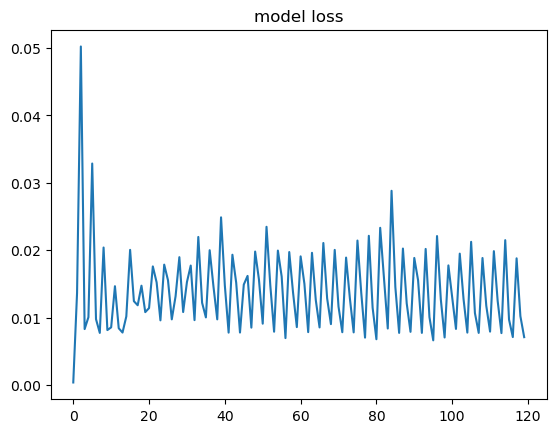

In [15]:
import matplotlib.pyplot as plt
# Visualize the loss evolution during training
plt.plot(losses)
plt.title('model loss')
plt.show()

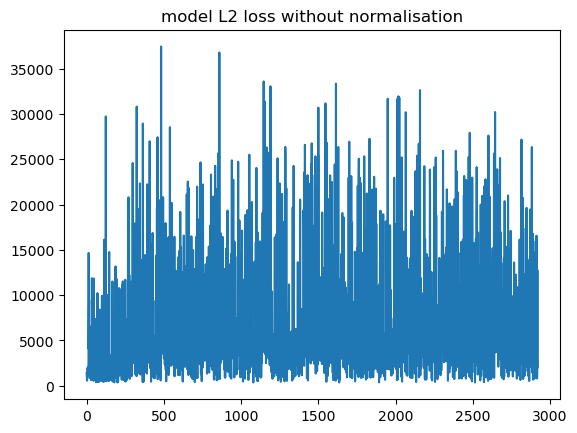

In [46]:
scaler = dataset.column_scalers[dataset.target_labels[0]]
#get the simple loss back from the squared error
scaled_losses = np.ravel(np.power(dataset.denormalize_values(np.sqrt(losses),scaler),2))
plt.plot(scaled_losses)
plt.title('model L2 loss without normalisation')
plt.show()

In [61]:
#now you can create a dataloader and use it!
dataloader = DataLoader(dataset, len(dataset), shuffle=False)

In [62]:
#visualize the model predictions
from tqdm import tqdm
real = []
pred = []
h, c = model.init_hidden(dataloader.batch_size) # Start with a new state in each batch            
h = h.to(device)
c = c.to(device)
for batch, data in tqdm(enumerate(dataloader),total=len(dataloader)):
    with torch.no_grad():
        #current batch size size
        ocu_emb, espai_enc, general_data = data["ocu_ber_emb"].float().to(device) ,data["espai_enc"].float().to(device) ,data["general_data"].float().to(device)
        y = data["y"][:,0].float().to(device) #we'll do one counter for now
        
        b_sz = ocu_emb.shape[0]
        h, c = model.init_hidden(b_sz) # Start with a new state in each batch            
        h = h.to(device)
        c = c.to(device)

        y_pred, h,c= model(ocu_emb, espai_enc, general_data, h, c)
        pred += list(y_pred[:,0,0].to("cpu"))
        real += list(y.to("cpu"))

100%|██████████| 1/1 [00:22<00:00, 22.26s/it]


In [51]:
def predict_consumption(model,dataloader):
    real = []
    pred = []
    h, c = model.init_hidden(dataloader.batch_size) # Start with a new state in each batch            
    h = h.to(device)
    c = c.to(device)
    for batch, data in enumerate(dataloader):
        with torch.no_grad():
            #current batch size size
            ocu_emb, espai_enc, general_data = data["ocu_ber_emb"].float().to(device) ,data["espai_enc"].float().to(device) ,data["general_data"].float().to(device)
            y = data["y"][:,0].float().to(device) #we'll do one counter for now
            
            b_sz = ocu_emb.shape[0]
            h, c = model.init_hidden(b_sz) # Start with a new state in each batch            
            h = h.to(device)
            c = c.to(device)

            y_pred, h,c= model(ocu_emb, espai_enc, general_data, h, c)
            pred += list(y_pred[:,0,0].to("cpu"))
            real += list(y.to("cpu"))
    return real ,pred

In [63]:
real = [v.item() for v in real]
pred = [v.item() for v in pred]

In [64]:
scaler = dataset.column_scalers[dataset.target_labels[0]]
real_sc = dataset.denormalize_values(real,scaler)
pred_sc = dataset.denormalize_values(pred,scaler)

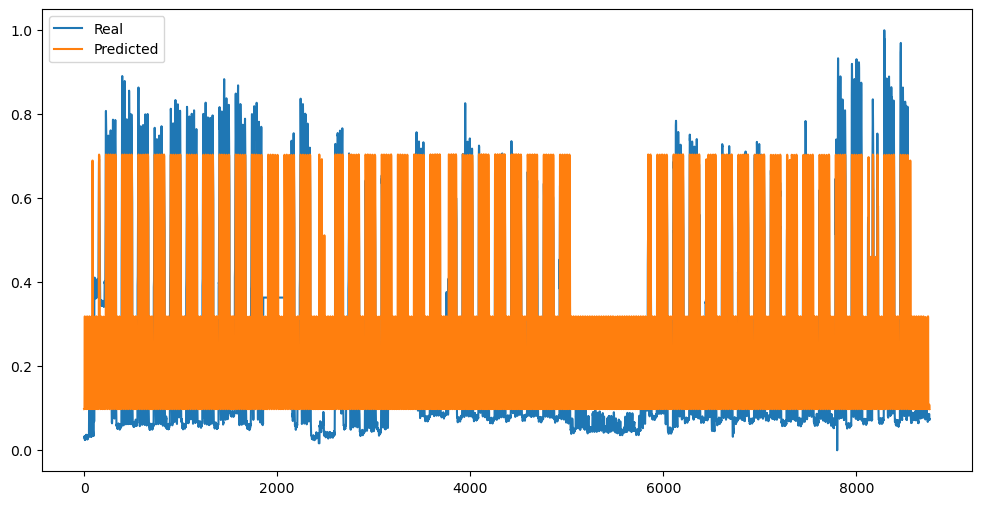

In [65]:
plt.figure(figsize=(12, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(real, label='Real')  # Add a label for the real data
plt.plot(pred, label='Predicted')  # Add a label for the predicted data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

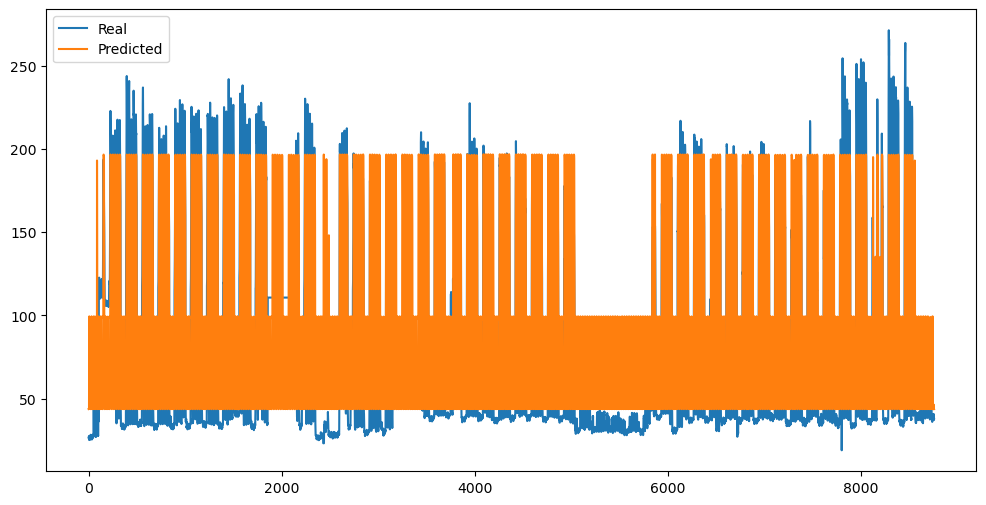

In [66]:
plt.figure(figsize=(12, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(real_sc, label='Real')  # Add a label for the real data
plt.plot(pred_sc, label='Predicted')  # Add a label for the predicted data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

Residual plot:

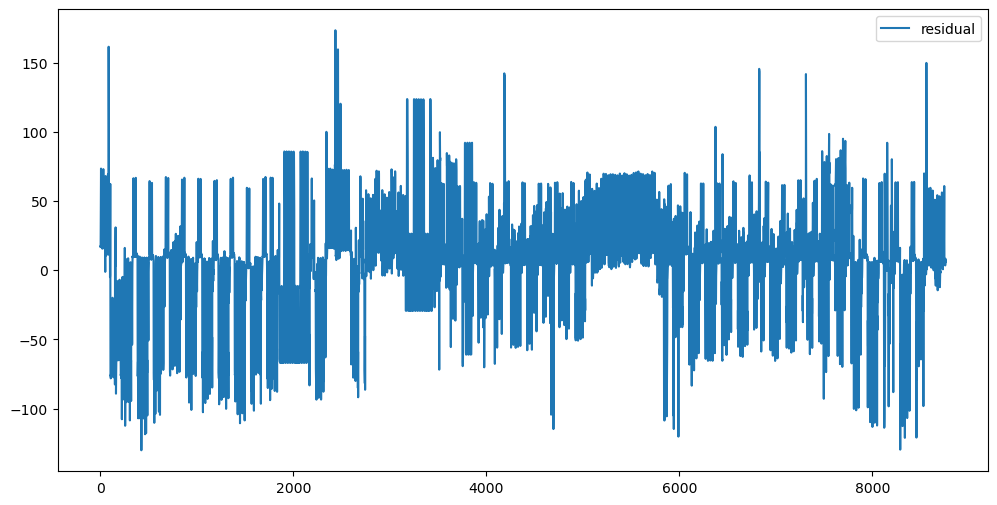

In [67]:
plt.figure(figsize=(12, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(pred_sc-real_sc, label='residual')  # Add a label for the real data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

### Try training with shuffle on and batchsize 1 so it is independent of past samples

Training on top of previous

In [11]:
#now you can create a dataloader and use it!
dataloader = DataLoader(dataset, 1, shuffle=True)

In [12]:
num_epochs = 10
losses = train(dataloader, model, batch_size=1, num_epochs=num_epochs,lr=0.0003)

{'epoch': 0, 'batch': 0, 'loss': 0.0020618834532797337}
{'epoch': 0, 'batch': 30, 'loss': 0.04694126173853874}
{'epoch': 0, 'batch': 60, 'loss': 0.04783538356423378}
{'epoch': 0, 'batch': 90, 'loss': 0.0013884382788091898}
{'epoch': 0, 'batch': 120, 'loss': 0.008989955298602581}
{'epoch': 0, 'batch': 150, 'loss': 0.00043730298057198524}
{'epoch': 0, 'batch': 180, 'loss': 0.006954110227525234}
{'epoch': 0, 'batch': 210, 'loss': 0.011619145050644875}
{'epoch': 0, 'batch': 240, 'loss': 0.010035841725766659}
{'epoch': 0, 'batch': 270, 'loss': 0.0001760736631695181}
{'epoch': 0, 'batch': 300, 'loss': 0.006977028213441372}
{'epoch': 0, 'batch': 330, 'loss': 0.0026083020493388176}
{'epoch': 0, 'batch': 360, 'loss': 0.003291620407253504}
{'epoch': 0, 'batch': 390, 'loss': 0.0014333856524899602}
{'epoch': 0, 'batch': 420, 'loss': 0.10546589642763138}
{'epoch': 0, 'batch': 450, 'loss': 0.0016184899723157287}
{'epoch': 0, 'batch': 480, 'loss': 0.13097260892391205}
{'epoch': 0, 'batch': 510, 'loss

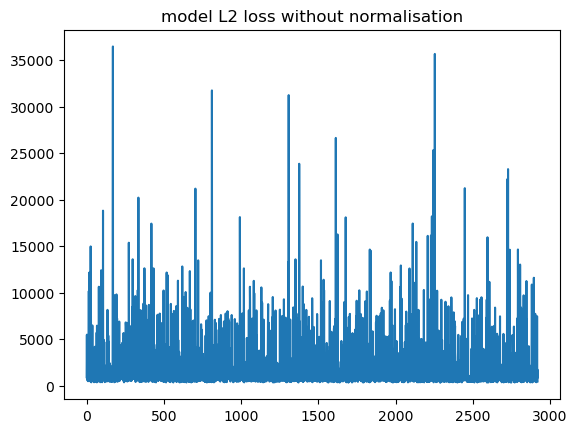

In [14]:
import matplotlib.pyplot as plt
scaler = dataset.column_scalers[dataset.target_labels[0]]
#get the simple loss back from the squared error
scaled_losses = np.ravel(np.power(dataset.denormalize_values(np.sqrt(losses),scaler),2))
plt.plot(scaled_losses)
plt.title('model L2 loss without normalisation')
plt.show()

Visualize how it predicts without seeing the past

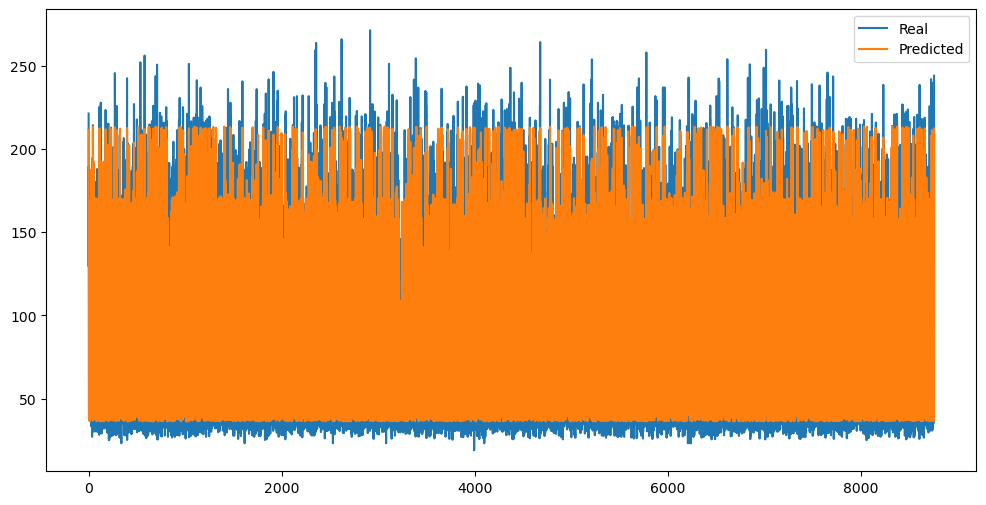

In [17]:
real, pred = predict_consumption(model,dataloader)
real = [v.item() for v in real]
pred = [v.item() for v in pred]
scaler = dataset.column_scalers[dataset.target_labels[0]]
real_sc = dataset.denormalize_values(real,scaler)
pred_sc = dataset.denormalize_values(pred,scaler)
plt.figure(figsize=(12, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(real_sc, label='Real')  # Add a label for the real data
plt.plot(pred_sc, label='Predicted')  # Add a label for the predicted data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

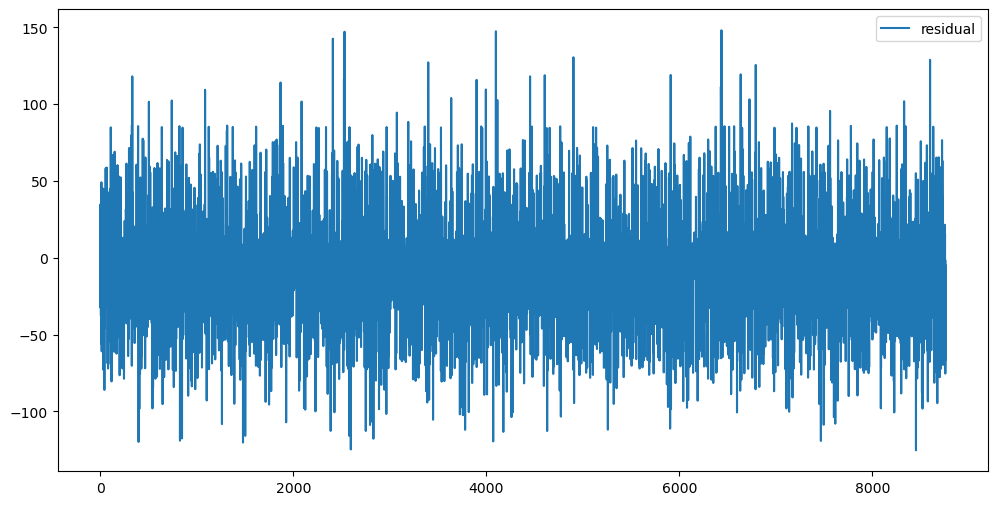

In [18]:
plt.figure(figsize=(12, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(pred_sc-real_sc, label='residual')  # Add a label for the real data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

And how it performs at the same task as before? (seeing past data continuosly)

In [19]:
#now you can create a dataloader and use it!
dataloader = DataLoader(dataset, len(dataset), shuffle=False)

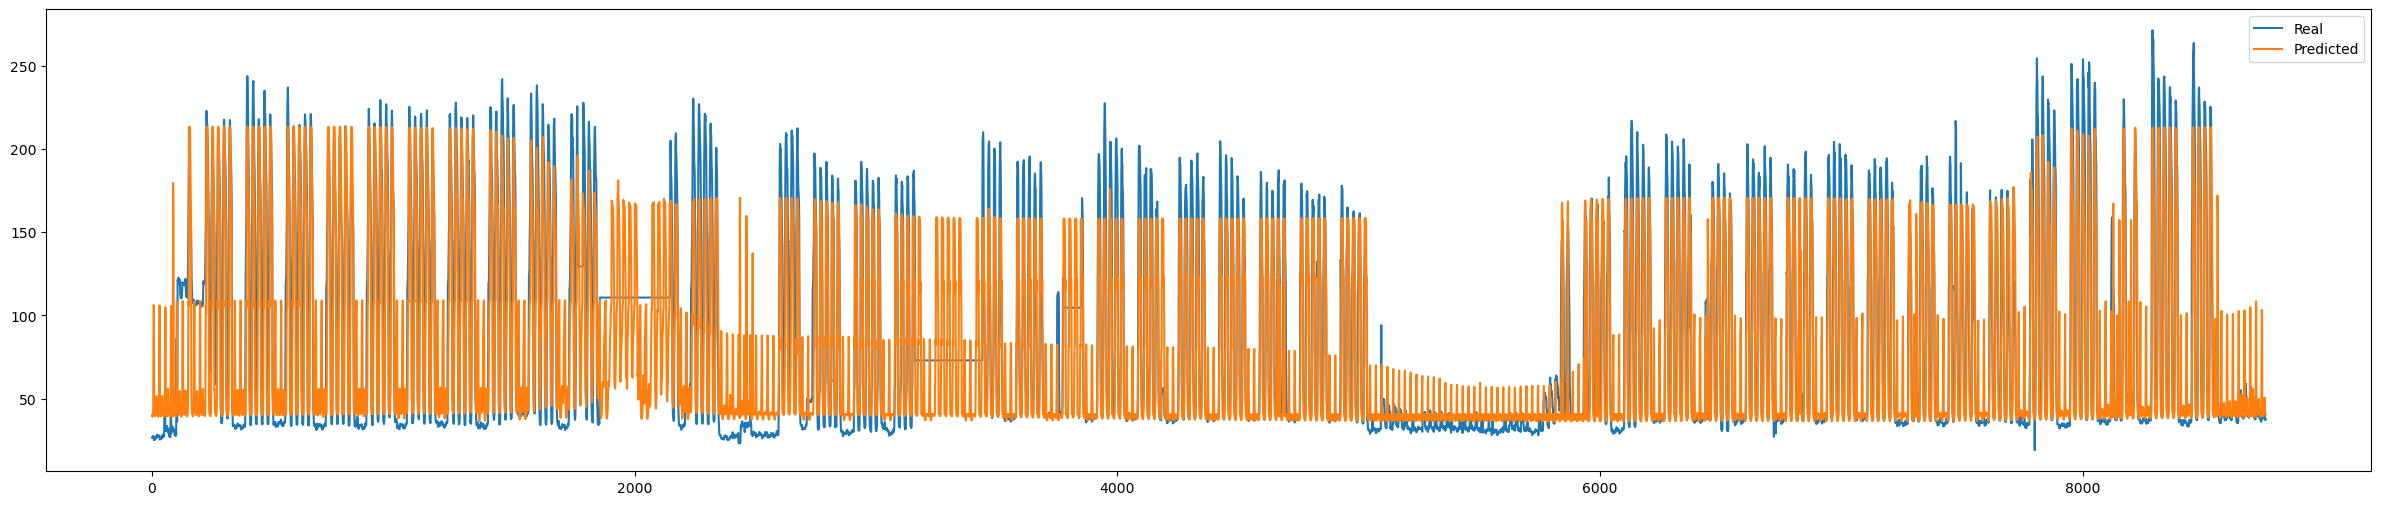

In [20]:
real, pred = predict_consumption(model,dataloader)
real = [v.item() for v in real]
pred = [v.item() for v in pred]
scaler = dataset.column_scalers[dataset.target_labels[0]]
real_sc = dataset.denormalize_values(real,scaler)
pred_sc = dataset.denormalize_values(pred,scaler)
plt.figure(figsize=(30, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(real_sc, label='Real')  # Add a label for the real data
plt.plot(pred_sc, label='Predicted')  # Add a label for the predicted data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

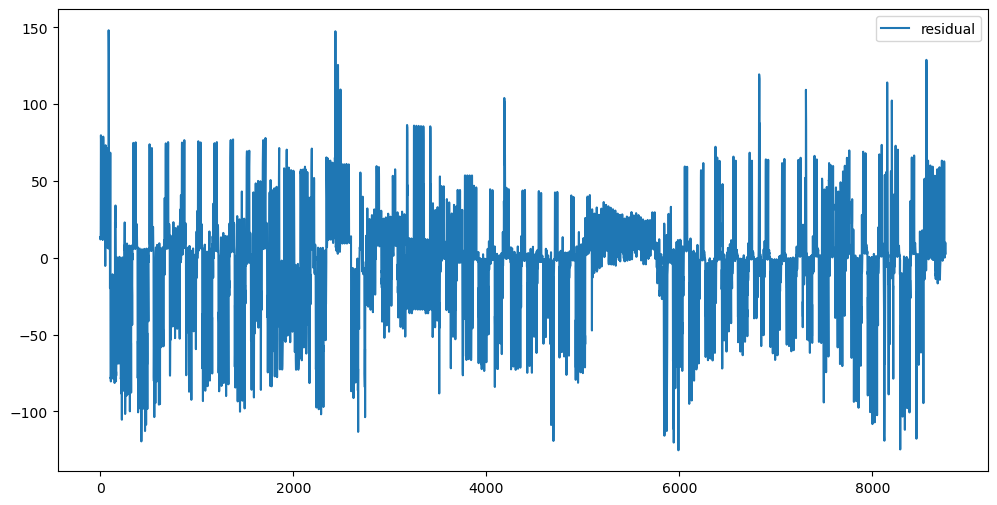

In [21]:
plt.figure(figsize=(12, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(pred_sc-real_sc, label='residual')  # Add a label for the real data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

Did help "fine tune" and learn importance of the daily information

In [22]:
torch.save(model, "models/attention_exp_LSTM/model1_ft.pth")

### How well does it perform if we train it for half a year or so and try to predict the other one?

In [25]:
model_tt = attentive_model_pepemarti(espai_emb_dim=30,hidden_dim=30,lstm_nl=1,target_dim=1)
model_tt.init_weights()
model_tt = model_tt.to(device)

In [26]:
trainset_train = torch.utils.data.Subset(dataset, np.arange(0,5000))
trainset_test = torch.utils.data.Subset(dataset, np.arange(5000,len(dataset)))
#now you can create a dataloader and use it!
batch_size = 100
dataloader_train = DataLoader(trainset_train, batch_size, shuffle=False)
dataloader_test = DataLoader(trainset_test, batch_size, shuffle=False)

In [27]:
num_epochs = 10
losses = train(dataloader_train, model_tt, batch_size=100, num_epochs=num_epochs)

{'epoch': 0, 'batch': 0, 'loss': 0.0019863068591803312}
{'epoch': 0, 'batch': 30, 'loss': 0.043915871530771255}
{'epoch': 1, 'batch': 0, 'loss': 0.059062227606773376}
{'epoch': 1, 'batch': 30, 'loss': 0.030728131532669067}
{'epoch': 2, 'batch': 0, 'loss': 0.02979259379208088}
{'epoch': 2, 'batch': 30, 'loss': 0.006165491882711649}
{'epoch': 3, 'batch': 0, 'loss': 0.023647388443350792}
{'epoch': 3, 'batch': 30, 'loss': 0.004192547872662544}
{'epoch': 4, 'batch': 0, 'loss': 0.015536549501121044}
{'epoch': 4, 'batch': 30, 'loss': 0.01492333598434925}
{'epoch': 5, 'batch': 0, 'loss': 0.02233477123081684}
{'epoch': 5, 'batch': 30, 'loss': 0.07587447017431259}
{'epoch': 6, 'batch': 0, 'loss': 0.030204905197024345}
{'epoch': 6, 'batch': 30, 'loss': 0.04455484449863434}
{'epoch': 7, 'batch': 0, 'loss': 0.07264663279056549}
{'epoch': 7, 'batch': 30, 'loss': 0.008999403566122055}
{'epoch': 8, 'batch': 0, 'loss': 0.02503901906311512}
{'epoch': 8, 'batch': 30, 'loss': 0.04118235409259796}
{'epoch'

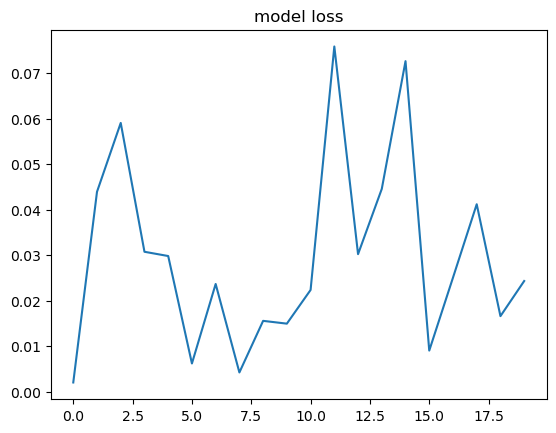

In [28]:
# Visualize the loss evolution during training
plt.plot(losses)
plt.title('model loss')
plt.show()

In [29]:
real, pred = predict_consumption(model_tt,dataloader_test)
real = [v.item() for v in real]
pred = [v.item() for v in pred]
scaler = dataset.column_scalers[dataset.target_labels[0]]
real_sc = dataset.denormalize_values(real,scaler)
pred_sc = dataset.denormalize_values(pred,scaler)

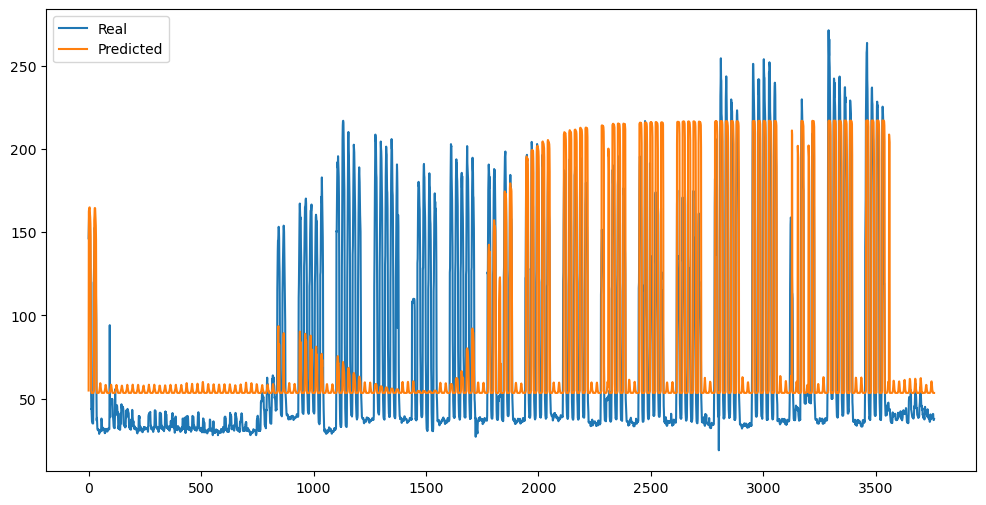

In [30]:
plt.figure(figsize=(12, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(real_sc, label='Real')  # Add a label for the real data
plt.plot(pred_sc, label='Predicted')  # Add a label for the predicted data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

Residual plot:

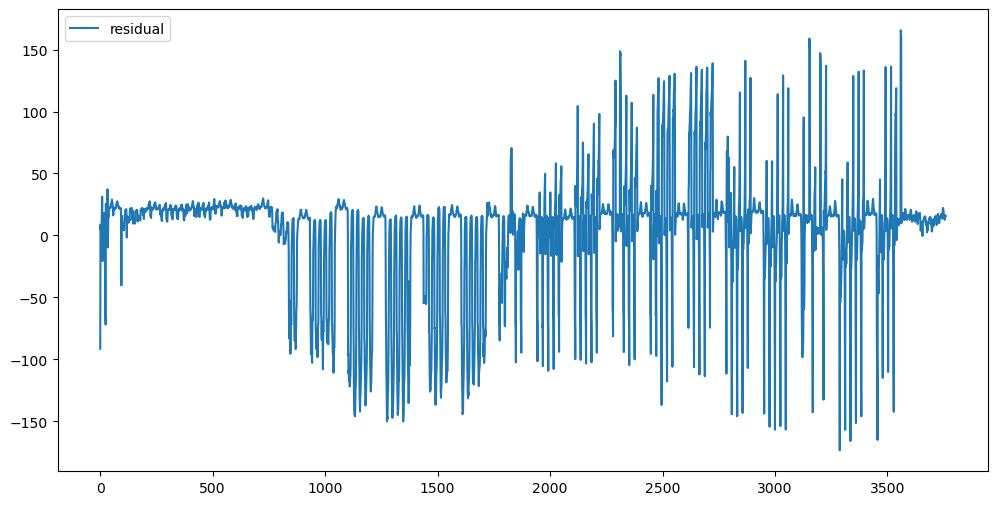

In [31]:
plt.figure(figsize=(12, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(pred_sc-real_sc, label='residual')  # Add a label for the real data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

Not bad, not bad. We see that it is learning some patterns. This is over unseen data

In [32]:
del model_tt

### Is the LSTM + FC part really learning what feature representations mean what or they have learned the sequence over a year?

We'll predict over the same sample all the time

In [33]:
real = []
pred = []
h, c = model.init_hidden(dataloader.batch_size) # Start with a new state in each batch            
h = h.to(device)
c = c.to(device)

#give extra batch dimension to sample
sample = dataset.__getitem__(0)
for i in range(1000):
    with torch.no_grad():
        #current batch size size
        ocu_emb, espai_enc, general_data = sample["ocu_ber_emb"].float().to(device) ,sample["espai_enc"].float().to(device) ,sample["general_data"].float().to(device)
        #give extra batch dimension to sample
        ocu_emb, espai_enc, general_data =   ocu_emb.unsqueeze(0), espai_enc.unsqueeze(0), general_data.unsqueeze(0)
        
        y = sample["y"][0].float().to(device) #we'll do one counter for now
        
        b_sz = ocu_emb.shape[0]
        h, c = model.init_hidden(b_sz) # Start with a new state in each batch            
        h = h.to(device)
        c = c.to(device)

        y_pred, h,c= model(ocu_emb, espai_enc, general_data, h, c)
        pred += list(y_pred[:,0,0].to("cpu"))
        real += [y.to("cpu")]

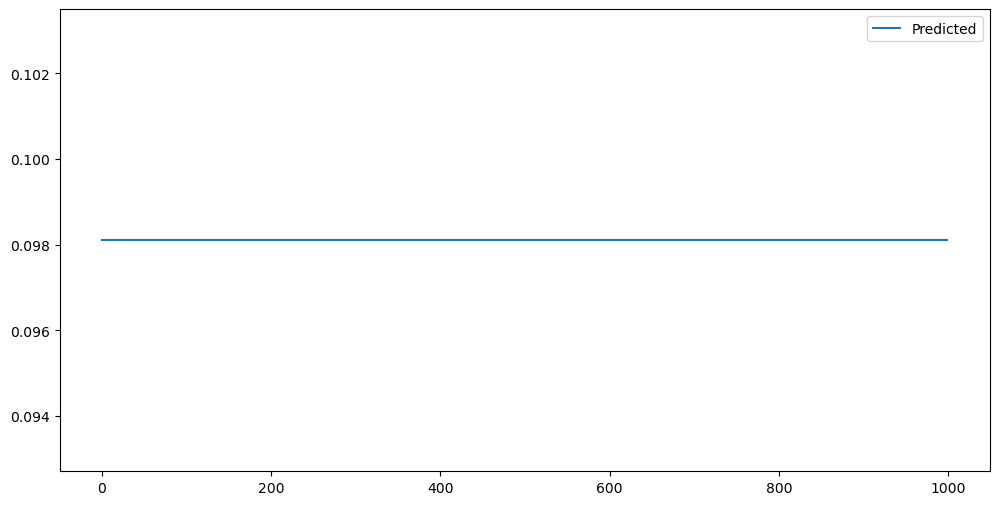

In [34]:
plt.figure(figsize=(12, 6))  # Increase the figure size to make it larger in the x-axis

#plt.plot(real, label='Real')  # Add a label for the real data
plt.plot(pred, label='Predicted')  # Add a label for the predicted data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

With a constant sample predicted a line, which is suggest that the encoding of activities, climate data and time are being learnt and have some impact.

## Solving the value clipping problem:

Hypotheses: Maybe the Relu is clipping the negative values so its hard for the network to create jumps in value under the bias. Or something like that. Change ReLu in the regressor FC to leaky relu

In [62]:
class attentive_model_pepemarti(nn.Module):
    def __init__(self, espai_emb_dim,hidden_dim,lstm_nl,target_dim):
        super(attentive_model_pepemarti, self).__init__()
        self.espai_emb_dim = espai_emb_dim
        self.hidden_dim = hidden_dim
        self.lstm_nl = lstm_nl

        self.espai_emb = nn.Embedding(num_embeddings=len(dataset.espais_vocab),embedding_dim=espai_emb_dim)
        self.classe_repr = nn.Sequential(
            nn.Linear(in_features=BERT_DIM_EMB+espai_emb_dim,out_features=601),
            nn.ReLU(),
            nn.Linear(in_features=601,out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256,out_features=51),
            nn.ReLU(),
            nn.Linear(in_features=51,out_features=TIME_CLIMATE_DIM),
            nn.Softmax(dim=-1)
        )

        self.key_gen =  nn.Sequential(
            nn.Linear(in_features=TIME_CLIMATE_DIM,out_features=40),
            nn.ReLU(),
            nn.Linear(in_features=40,out_features=hidden_dim),
            nn.Softmax(dim=-1)
        )

        self.val_gen =  nn.Sequential(
            nn.Linear(in_features=TIME_CLIMATE_DIM,out_features=40),
            nn.ReLU(),
            nn.Linear(in_features=40,out_features=hidden_dim),
            nn.ReLU(),
        )

        self.query_gen =  nn.Sequential(
            nn.Linear(in_features=TIME_CLIMATE_DIM,out_features=40),
            nn.ReLU(),
            nn.Linear(in_features=40,out_features=hidden_dim),
            nn.Softmax(dim=-1)
        )
        
        self.multihead_attn = nn.MultiheadAttention(hidden_dim,3,batch_first=True)
        
        self.lstm = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=self.lstm_nl, dropout=0, batch_first=True) #input -> BATCH, SEQ_LENGHT, EMBEDDING_DIM
        
        self.regressFC = nn.Linear(in_features=self.hidden_dim,out_features=1)

    def forward(self,ocu_ber_emb,espai_enc,general_data,h,c):
        #embedd the espais
        espai_emb = self.espai_emb(espai_enc.to(torch.int)).float()
        #concatenate activity and espai vector
        act_cat_espai = torch.cat((ocu_ber_emb,espai_emb),axis=2)

        #pass act_cat_espai through a FC to have a "classe" representation
        classe_repr = self.classe_repr(act_cat_espai.float())
    
        #get this representation and multiply it with the general data "sort of attention here"
        #first extend the general data so we have a pair for each class vector
        general_rep = general_data.unsqueeze(1).repeat(1, 34, 1)
        general_at_per_class = general_rep * classe_repr #element wise multiplication
        general_at_per_class = general_at_per_class.float() #convert to float32

        key = self.key_gen(general_at_per_class) #generate key with FC
        value = self.val_gen(general_at_per_class) #generate value with FC
        query = self.query_gen(general_at_per_class) #generate query with FC
        
        #att_mask = torch.sum(ocu_ber_emb,axis=2) != 0.0 #look for what values have to enter. The ones that aren't padding
        #att_mask = att_mask.unsqueeze(1)
        #att_mask = att_mask.repeat(3, att_mask.shape[2], 1)#repeat 3 times along batch dim because we have three heads. The other repeat is because we need it to be of shape seqlenxseqlen 
        #output, _ =  self.multihead_attn(key=key, value=value, query=query,attn_mask=att_mask)
        output, _ =  self.multihead_attn(key=key, value=value, query=query)
        output = torch.sum(output,axis=1)

        #create extra to output be a sequence of 1
        output = output.unsqueeze(1)
        
        #pass this as the inital state to a LSTM
        out, (h,c) = self.lstm(output, (h,c))
        out =  self.regressFC(out).float()
        #ic(out.shape)
        return out, h, c
    
    def init_hidden(self,batch_size):
        # Initialize the hidden state and cell state with zeros
        h = torch.zeros(self.lstm_nl, batch_size, self.hidden_dim,dtype=torch.float32)
        c = torch.zeros(self.lstm_nl, batch_size, self.hidden_dim,dtype=torch.float32)
        return h, c

    def init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)
    

Train again:

In [63]:
del model

In [64]:
model = attentive_model_pepemarti(espai_emb_dim=30,hidden_dim=30,lstm_nl=1,target_dim=1)

In [65]:
model.init_weights()
model = model.to(device)

In [66]:
#now you can create a dataloader and use it!
batch_size = 100
dataloader = DataLoader(dataset, batch_size, shuffle=False)

In [67]:
num_epochs = 20
losses = train(dataloader, model, batch_size=100, num_epochs=num_epochs)

{'epoch': 0, 'batch': 0, 'loss': 0.01222065556794405}
{'epoch': 0, 'batch': 30, 'loss': 0.012230508029460907}
{'epoch': 0, 'batch': 60, 'loss': 0.048876676708459854}
{'epoch': 1, 'batch': 0, 'loss': 0.029377179220318794}
{'epoch': 1, 'batch': 30, 'loss': 0.010583077557384968}
{'epoch': 1, 'batch': 60, 'loss': 0.03692203015089035}
{'epoch': 2, 'batch': 0, 'loss': 0.018124984577298164}
{'epoch': 2, 'batch': 30, 'loss': 0.0112025560811162}
{'epoch': 2, 'batch': 60, 'loss': 0.02528919093310833}
{'epoch': 3, 'batch': 0, 'loss': 0.016070498153567314}
{'epoch': 3, 'batch': 30, 'loss': 0.011429520323872566}
{'epoch': 3, 'batch': 60, 'loss': 0.014955448918044567}
{'epoch': 4, 'batch': 0, 'loss': 0.018949933350086212}
{'epoch': 4, 'batch': 30, 'loss': 0.012865706346929073}
{'epoch': 4, 'batch': 60, 'loss': 0.014090287499129772}
{'epoch': 5, 'batch': 0, 'loss': 0.015594616532325745}
{'epoch': 5, 'batch': 30, 'loss': 0.013268168084323406}
{'epoch': 5, 'batch': 60, 'loss': 0.012521476484835148}
{'e

In [45]:
torch.save(model, "models/attention_exp_LSTM/model2.pth")

In [46]:
model = torch.load( "models/attention_exp_LSTM/model2.pth")

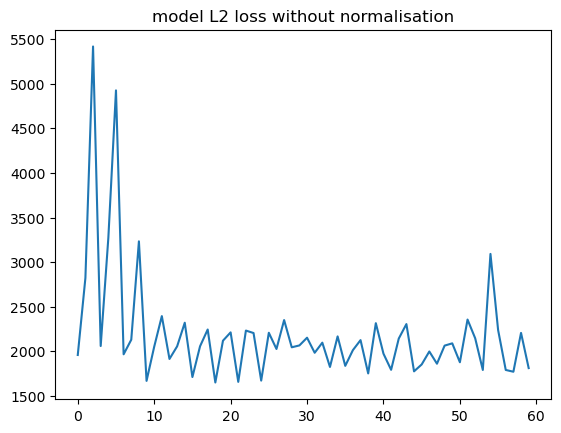

In [57]:
scaler = dataset.column_scalers[dataset.target_labels[0]]
#get the simple loss back from the squared error
scaled_losses = np.ravel(np.power(dataset.denormalize_values(np.sqrt(losses),scaler),2))
plt.plot(scaled_losses)
plt.title('model L2 loss without normalisation')
plt.show()

In [58]:
#now you can create a dataloader and use it!
dataloader = DataLoader(dataset, len(dataset), shuffle=False)

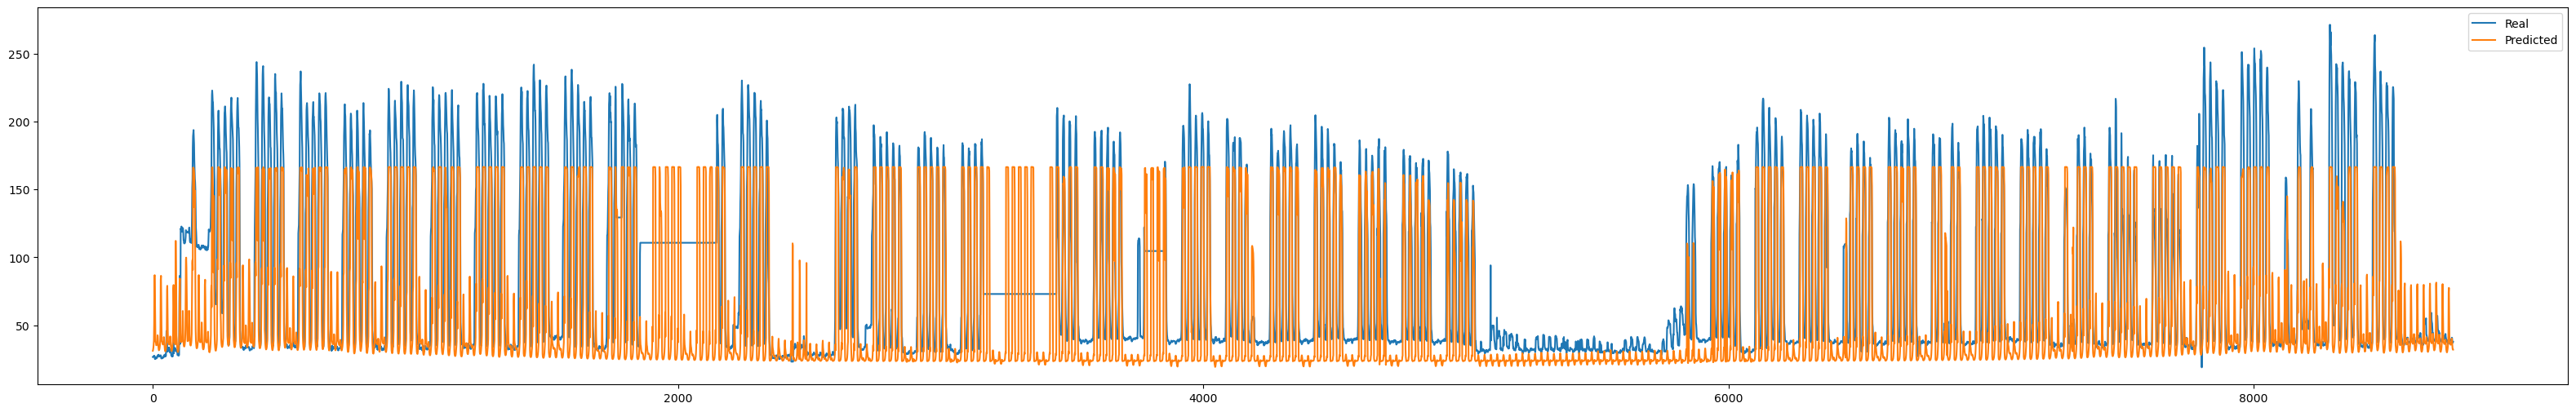

In [68]:
real, pred = predict_consumption(model,dataloader)
real = [v.item() for v in real]
pred = [v.item() for v in pred]
scaler = dataset.column_scalers[dataset.target_labels[0]]
real_sc = dataset.denormalize_values(real,scaler)
pred_sc = dataset.denormalize_values(pred,scaler)
plt.figure(figsize=(40, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(real_sc, label='Real')  # Add a label for the real data
plt.plot(pred_sc, label='Predicted')  # Add a label for the predicted data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

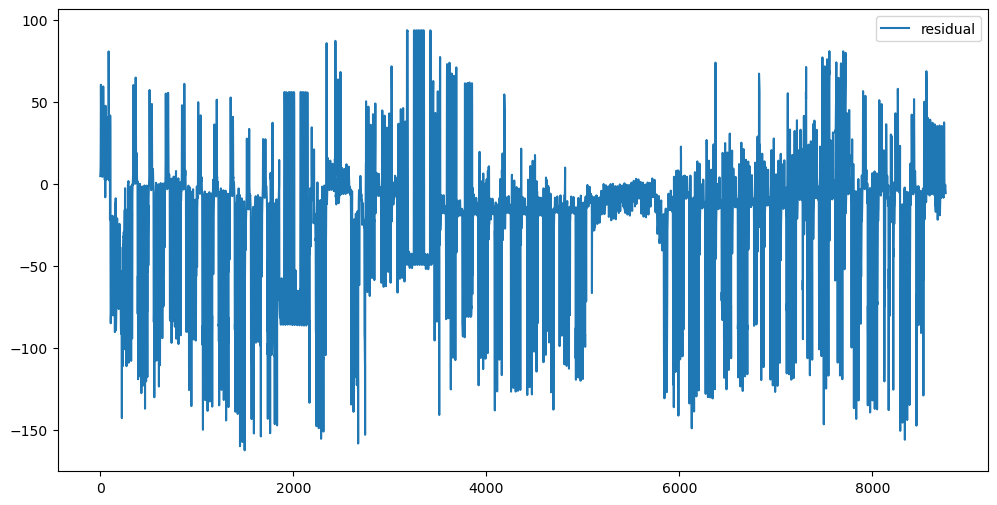

In [69]:
plt.figure(figsize=(12, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(pred_sc-real_sc, label='residual')  # Add a label for the real data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

### Trying to simplify

Things changed: Removed squeeze attention and fed to attention the espai embedding directly as a key, activ -> FC as query , repeated climate data -> FC as values. Added the resulting vectors and directly to a linear layer for regresion.

In [77]:
class attentive_model_pepemarti(nn.Module):
    def __init__(self, espai_emb_dim,hidden_dim,lstm_nl,target_dim):
        super(attentive_model_pepemarti, self).__init__()
        self.espai_emb_dim = espai_emb_dim
        self.hidden_dim = hidden_dim
        self.lstm_nl = lstm_nl

        self.espai_emb = nn.Embedding(num_embeddings=len(dataset.espais_vocab),embedding_dim=espai_emb_dim)
        self.classe_repr = nn.Sequential(
            nn.Linear(in_features=BERT_DIM_EMB+espai_emb_dim,out_features=601),
            nn.ReLU(),
            nn.Linear(in_features=601,out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256,out_features=51),
            nn.ReLU(),
            nn.Linear(in_features=51,out_features=TIME_CLIMATE_DIM),
            nn.Softmax(dim=-1)
        )

        self.val_gen =  nn.Sequential(
            nn.Linear(in_features=TIME_CLIMATE_DIM,out_features=40),
            nn.ReLU(),
            nn.Linear(in_features=40,out_features=hidden_dim),
            nn.ReLU(),
        )

        self.query_gen =  nn.Sequential(
            nn.Linear(in_features=BERT_DIM_EMB,out_features=40),
            nn.ReLU(),
            nn.Linear(in_features=40,out_features=hidden_dim),
            nn.Softmax(dim=-1)
        )
        
        self.multihead_attn = nn.MultiheadAttention(hidden_dim,3,batch_first=True)
        
        self.lstm = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=self.lstm_nl, dropout=0, batch_first=True) #input -> BATCH, SEQ_LENGHT, EMBEDDING_DIM
        
        self.regressFC = nn.Linear(in_features=hidden_dim,out_features=1)

    def forward(self,ocu_ber_emb,espai_enc,general_data,h,c):
        #embedd the espais
        espai_emb = self.espai_emb(espai_enc.to(torch.int)).float()
    
        #first extend the general data so we have a pair for each class vector
        general_rep = general_data.unsqueeze(1).repeat(1, 34, 1)

        #key = self.key_gen(espai_emb) #generate key with FC key is directly the embedding
        value = self.val_gen(general_rep) #generate value with FC
        query = self.query_gen(ocu_ber_emb) #generate query with FC
        
        #att_mask = torch.sum(ocu_ber_emb,axis=2) != 0.0 #look for what values have to enter. The ones that aren't padding
        #att_mask = att_mask.unsqueeze(1)
        #att_mask = att_mask.repeat(3, att_mask.shape[2], 1)#repeat 3 times along batch dim because we have three heads. The other repeat is because we need it to be of shape seqlenxseqlen 
        #output, _ =  self.multihead_attn(key=key, value=value, query=query,attn_mask=att_mask)
        output, _ =  self.multihead_attn(key=espai_emb, value=value, query=query)
        output = torch.sum(output,axis=1)

        #create extra to output be a sequence of 1
        #output = output.unsqueeze(1)
        
        #pass this as the inital state to a LSTM
        #out, (h,c) = self.lstm(output, (h,c))
        #ic(general_at_per_class.shape)
        #out = torch.reshape(output,(output.shape[0],output.shape[1]*output.shape[2]))
        #ic(out.shape)
        out =  self.regressFC(output).float()
        out = out.unsqueeze(1) #extra dim to reuse train and predict function
        return out, h, c
    
    def init_hidden(self,batch_size):
        # Initialize the hidden state and cell state with zeros
        h = torch.zeros(self.lstm_nl, batch_size, self.hidden_dim,dtype=torch.float32)
        c = torch.zeros(self.lstm_nl, batch_size, self.hidden_dim,dtype=torch.float32)
        return h, c

    def init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

In [78]:
del model

In [79]:
model = attentive_model_pepemarti(espai_emb_dim=30,hidden_dim=30,lstm_nl=1,target_dim=1)

In [80]:
model.init_weights()
model = model.to(device)

In [81]:
#now you can create a dataloader and use it!
batch_size = 100
dataloader = DataLoader(dataset, batch_size, shuffle=False)

In [82]:
num_epochs = 20
losses = train(dataloader, model, batch_size=100, num_epochs=num_epochs)

{'epoch': 0, 'batch': 0, 'loss': 238.7147979736328}
{'epoch': 0, 'batch': 30, 'loss': 2.3881776332855225}
{'epoch': 0, 'batch': 60, 'loss': 0.6245896816253662}
{'epoch': 1, 'batch': 0, 'loss': 1.0314178466796875}
{'epoch': 1, 'batch': 30, 'loss': 0.6211588978767395}
{'epoch': 1, 'batch': 60, 'loss': 0.4756023585796356}
{'epoch': 2, 'batch': 0, 'loss': 0.9038734436035156}
{'epoch': 2, 'batch': 30, 'loss': 0.34013888239860535}
{'epoch': 2, 'batch': 60, 'loss': 0.4870738089084625}
{'epoch': 3, 'batch': 0, 'loss': 0.5968427658081055}
{'epoch': 3, 'batch': 30, 'loss': 0.37291038036346436}
{'epoch': 3, 'batch': 60, 'loss': 0.358764111995697}
{'epoch': 4, 'batch': 0, 'loss': 0.37879064679145813}
{'epoch': 4, 'batch': 30, 'loss': 0.4588121771812439}
{'epoch': 4, 'batch': 60, 'loss': 0.20276179909706116}
{'epoch': 5, 'batch': 0, 'loss': 0.5585442781448364}
{'epoch': 5, 'batch': 30, 'loss': 0.3351294994354248}
{'epoch': 5, 'batch': 60, 'loss': 0.3449136018753052}
{'epoch': 6, 'batch': 0, 'loss':

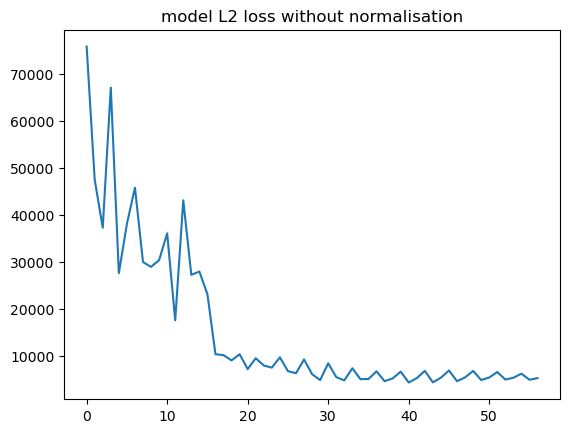

In [88]:
import matplotlib.pyplot as plt
scaler = dataset.column_scalers[dataset.target_labels[0]]
#get the simple loss back from the squared error
scaled_losses = np.ravel(np.power(dataset.denormalize_values(np.sqrt(losses),scaler),2))
plt.plot(scaled_losses[3:])
plt.title('model L2 loss without normalisation')
plt.show()

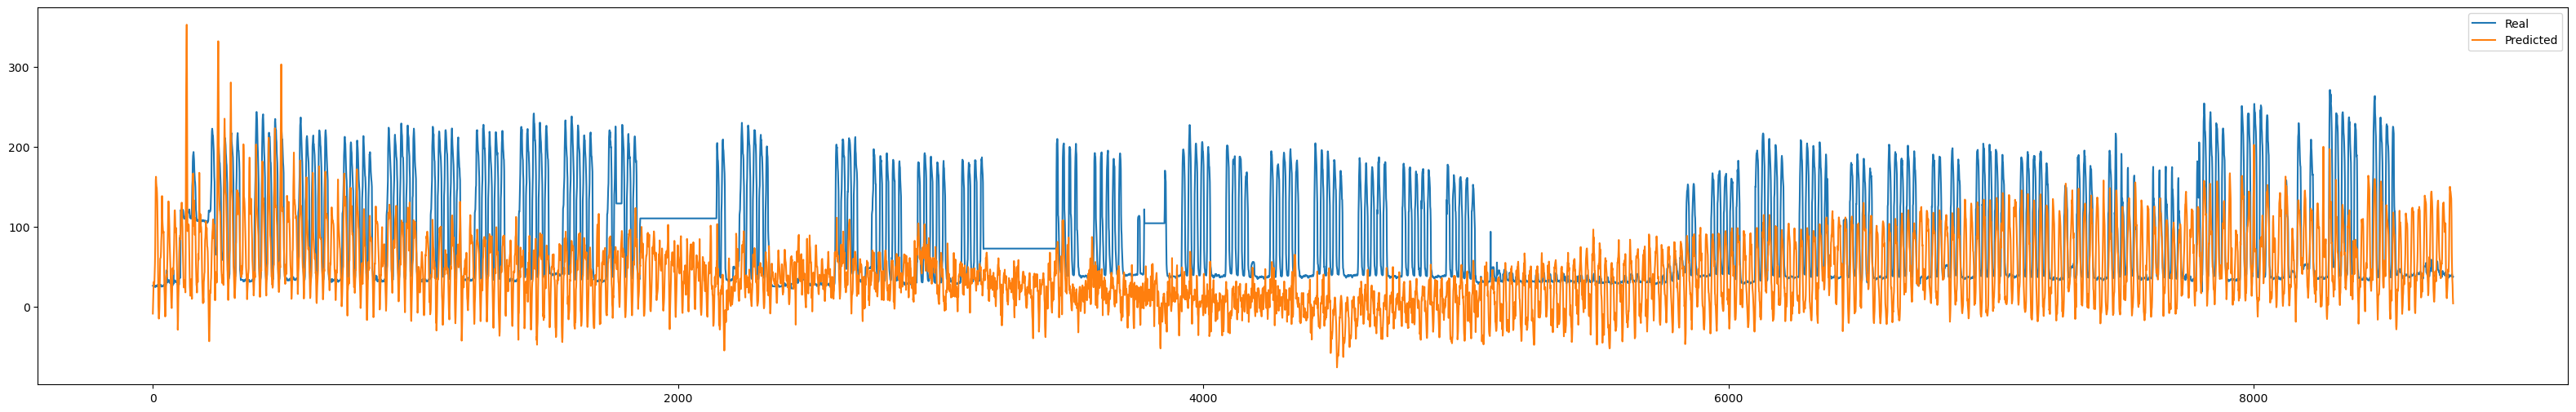

In [85]:
real, pred = predict_consumption(model,dataloader)
real = [v.item() for v in real]
pred = [v.item() for v in pred]
scaler = dataset.column_scalers[dataset.target_labels[0]]
real_sc = dataset.denormalize_values(real,scaler)
pred_sc = dataset.denormalize_values(pred,scaler)
plt.figure(figsize=(40, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(real_sc, label='Real')  # Add a label for the real data
plt.plot(pred_sc, label='Predicted')  # Add a label for the predicted data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

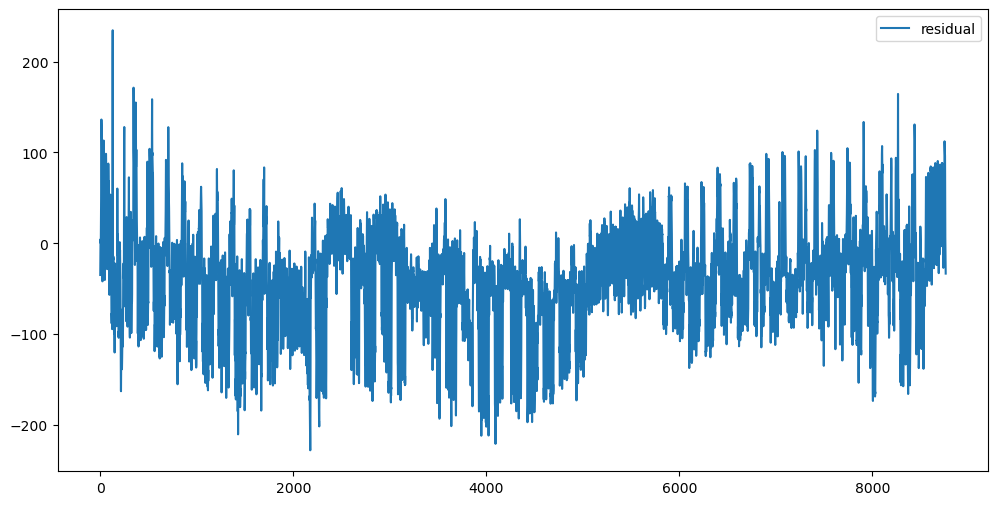

In [89]:
plt.figure(figsize=(12, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(pred_sc-real_sc, label='residual')  # Add a label for the real data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

Now instead of passing the current value to the linear layer first go through the LSTM

In [ ]:
class attentive_model_pepemarti(nn.Module):
    def __init__(self, espai_emb_dim,hidden_dim,lstm_nl,target_dim):
        super(attentive_model_pepemarti, self).__init__()
        self.espai_emb_dim = espai_emb_dim
        self.hidden_dim = hidden_dim
        self.lstm_nl = lstm_nl

        self.espai_emb = nn.Embedding(num_embeddings=len(dataset.espais_vocab),embedding_dim=espai_emb_dim)
        self.classe_repr = nn.Sequential(
            nn.Linear(in_features=BERT_DIM_EMB+espai_emb_dim,out_features=601),
            nn.ReLU(),
            nn.Linear(in_features=601,out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256,out_features=51),
            nn.ReLU(),
            nn.Linear(in_features=51,out_features=TIME_CLIMATE_DIM),
            nn.Softmax(dim=-1)
        )

        self.val_gen =  nn.Sequential(
            nn.Linear(in_features=TIME_CLIMATE_DIM,out_features=40),
            nn.ReLU(),
            nn.Linear(in_features=40,out_features=hidden_dim),
            nn.ReLU(),
        )

        self.query_gen =  nn.Sequential(
            nn.Linear(in_features=BERT_DIM_EMB,out_features=40),
            nn.ReLU(),
            nn.Linear(in_features=40,out_features=hidden_dim),
            nn.Softmax(dim=-1)
        )
        
        self.multihead_attn = nn.MultiheadAttention(hidden_dim,3,batch_first=True)
        
        self.lstm = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=self.lstm_nl, dropout=0, batch_first=True) #input -> BATCH, SEQ_LENGHT, EMBEDDING_DIM
        
        self.regressFC = nn.Linear(in_features=hidden_dim,out_features=1)

    def forward(self,ocu_ber_emb,espai_enc,general_data,h,c):
        #embedd the espais
        espai_emb = self.espai_emb(espai_enc.to(torch.int)).float()
    
        #first extend the general data so we have a pair for each class vector
        general_rep = general_data.unsqueeze(1).repeat(1, 34, 1)

        #key = self.key_gen(espai_emb) #generate key with FC key is directly the embedding
        value = self.val_gen(general_rep) #generate value with FC
        query = self.query_gen(ocu_ber_emb) #generate query with FC
        
        #att_mask = torch.sum(ocu_ber_emb,axis=2) != 0.0 #look for what values have to enter. The ones that aren't padding
        #att_mask = att_mask.unsqueeze(1)
        #att_mask = att_mask.repeat(3, att_mask.shape[2], 1)#repeat 3 times along batch dim because we have three heads. The other repeat is because we need it to be of shape seqlenxseqlen 
        #output, _ =  self.multihead_attn(key=key, value=value, query=query,attn_mask=att_mask)
        output, _ =  self.multihead_attn(key=espai_emb, value=value, query=query)
        output = torch.sum(output,axis=1)

        #create extra to output be a sequence of 1
        output = output.unsqueeze(1)
        
        #pass this as the inital state to a LSTM
        out, (h,c) = self.lstm(output, (h,c))
        out =  self.regressFC(output).float()
        out = out.unsqueeze(1) #extra dim to reuse train and predict function
        return out, h, c
    
    def init_hidden(self,batch_size):
        # Initialize the hidden state and cell state with zeros
        h = torch.zeros(self.lstm_nl, batch_size, self.hidden_dim,dtype=torch.float32)
        c = torch.zeros(self.lstm_nl, batch_size, self.hidden_dim,dtype=torch.float32)
        return h, c

    def init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

In [90]:
del model

In [91]:
model = attentive_model_pepemarti(espai_emb_dim=30,hidden_dim=30,lstm_nl=1,target_dim=1)

In [94]:
model.init_weights()
model = model.to(device)

In [92]:
#now you can create a dataloader and use it!
batch_size = 100
dataloader = DataLoader(dataset, batch_size, shuffle=False)

In [95]:
num_epochs = 20
losses = train(dataloader, model, batch_size=100, num_epochs=num_epochs)

{'epoch': 0, 'batch': 0, 'loss': 11.50868034362793}
{'epoch': 0, 'batch': 30, 'loss': 1.4506781101226807}
{'epoch': 0, 'batch': 60, 'loss': 0.42151564359664917}
{'epoch': 1, 'batch': 0, 'loss': 0.2903802692890167}
{'epoch': 1, 'batch': 30, 'loss': 0.8286929130554199}
{'epoch': 1, 'batch': 60, 'loss': 0.20216037333011627}
{'epoch': 2, 'batch': 0, 'loss': 0.12018577009439468}
{'epoch': 2, 'batch': 30, 'loss': 0.25337401032447815}
{'epoch': 2, 'batch': 60, 'loss': 0.18289092183113098}
{'epoch': 3, 'batch': 0, 'loss': 0.06607954204082489}
{'epoch': 3, 'batch': 30, 'loss': 0.13115522265434265}
{'epoch': 3, 'batch': 60, 'loss': 0.1400330662727356}
{'epoch': 4, 'batch': 0, 'loss': 0.06263301521539688}
{'epoch': 4, 'batch': 30, 'loss': 0.08318747580051422}
{'epoch': 4, 'batch': 60, 'loss': 0.08430099487304688}
{'epoch': 5, 'batch': 0, 'loss': 0.06830872595310211}
{'epoch': 5, 'batch': 30, 'loss': 0.06456572562456131}
{'epoch': 5, 'batch': 60, 'loss': 0.054762423038482666}
{'epoch': 6, 'batch':

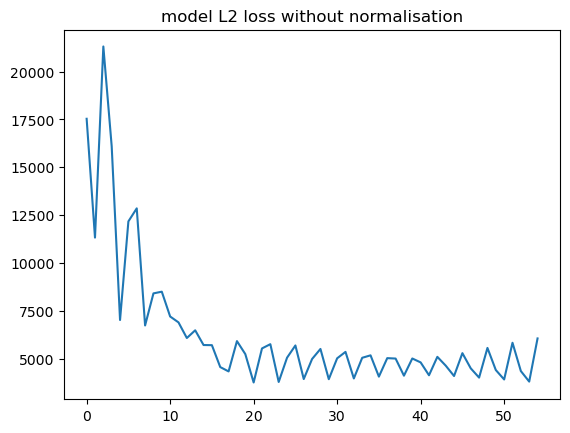

In [101]:
import matplotlib.pyplot as plt
scaler = dataset.column_scalers[dataset.target_labels[0]]
#get the simple loss back from the squared error
scaled_losses = np.ravel(np.power(dataset.denormalize_values(np.sqrt(losses),scaler),2))
plt.plot(scaled_losses[5:])
plt.title('model L2 loss without normalisation')
plt.show()

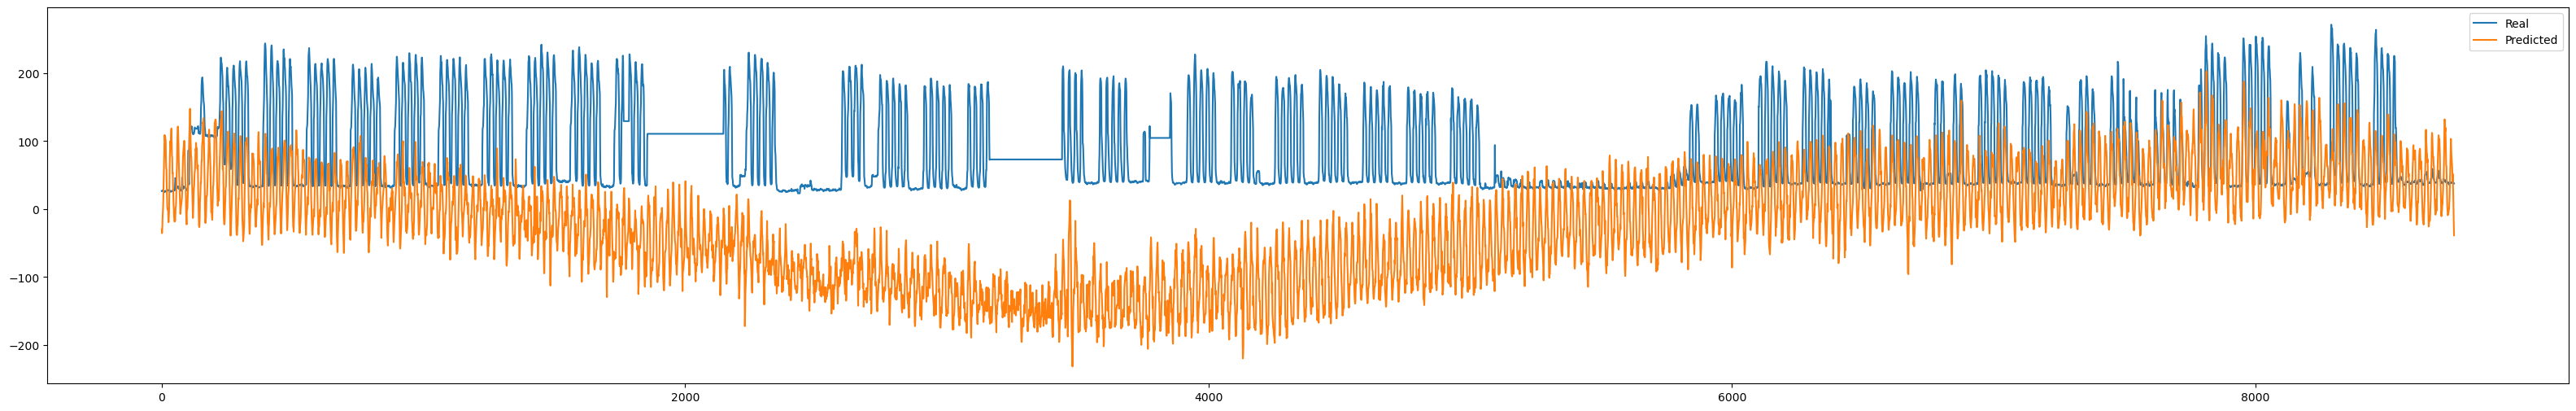

In [97]:
real, pred = predict_consumption(model,dataloader)
real = [v.item() for v in real]
pred = [v.item() for v in pred]
scaler = dataset.column_scalers[dataset.target_labels[0]]
real_sc = dataset.denormalize_values(real,scaler)
pred_sc = dataset.denormalize_values(pred,scaler)
plt.figure(figsize=(40, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(real_sc, label='Real')  # Add a label for the real data
plt.plot(pred_sc, label='Predicted')  # Add a label for the predicted data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

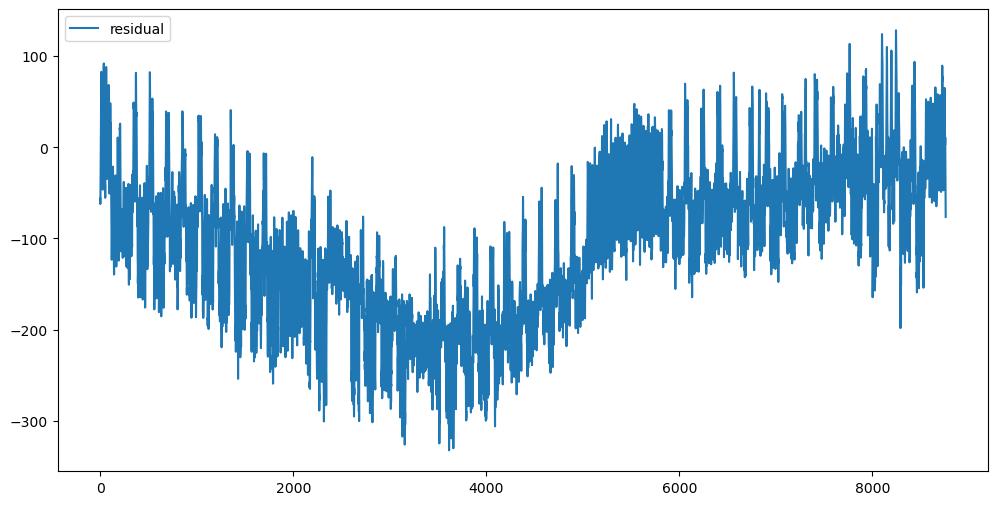

In [98]:
plt.figure(figsize=(12, 6))  # Increase the figure size to make it larger in the x-axis

plt.plot(pred_sc-real_sc, label='residual')  # Add a label for the real data

plt.legend()  # Add a legend to the plot

plt.show()  # Display the plot

We can conclude that the gating thing is doing something. So we'll keep it. But in the end it was the same of what we have implemented now right? an attention layer.
We'll try layering those creating in essence a transformer.

Maybe set them up in a way we can process a whole batch in one go?